# Time Series Prediction

This data was sunthesized after reconstructing digitizing a plot from Toronto Hydro PDF then finding the mean and standard deviation fro every time slice in the contructed graph for several days worth of data. This proviided  a gaussian distribution that could be sampled from to generate an infinite number of datas worth of data. Severl such days of synthetic data have been saved in anomaly.csv.

We use this data as a starting point to generate new data in the desired Chronos format: anomalySeries.csv

Then following the tutorial from Article: **Forecasting with Chronos**
- https://auto.gluon.ai/stable/tutorials/timeseries/forecasting-chronos.html



In [1]:
#!pip install git+https://github.com/amazon-science/chronos-forecasting.git


In [2]:
from autogluon.timeseries import TimeSeriesDataFrame, TimeSeriesPredictor

/home/u9999ad7367849478acc6568ce06912b/.local/lib/python3.9/site-packages/networkx/utils/backends.py:135: RuntimeWarning: networkx backend defined more than once: nx-loopback
  backends.update(_get_backends("networkx.backends"))


In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from chronos import ChronosPipeline
from tqdm.auto import tqdm

[2024-05-10 14:31:42,840] [INFO] [real_accelerator.py:191:get_accelerator] Setting ds_accelerator to cuda (auto detect)


# Anomaly

In [4]:
pipeline = ChronosPipeline.from_pretrained(
  "amazon/chronos-t5-base",
  device_map="cpu", 
  torch_dtype=torch.bfloat16,
)

In [5]:
data = TimeSeriesDataFrame(
    "anomalySeries.csv"
)
data.head()

target
item_id timestamp                      
Series  1750-01-01 00:00:00   91.979918
        1750-01-01 00:30:00   87.912618
        1750-01-01 01:00:00   86.553241
        1750-01-01 01:30:00  103.214549
        1750-01-01 02:00:00  111.290193

In [6]:
prediction_length = 24
train_data, test_data = data.train_test_split(prediction_length)

predictor = TimeSeriesPredictor(prediction_length=prediction_length).fit(
    train_data, presets="chronos_tiny",
)

Beginning AutoGluon training...
AutoGluon will save models to 'AutogluonModels/ag-20240510_213150'
=================== System Info ===================
AutoGluon Version:  1.1.0
Python Version:     3.9.18
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #116-Ubuntu SMP Wed Apr 17 09:17:56 UTC 2024
CPU Count:          224
GPU Count:          0
Memory Avail:       423.92 GB / 440.61 GB (96.2%)
Disk Space Avail:   61545.59 GB / 114157.16 GB (53.9%)
Setting presets to: chronos_tiny

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperparameters': {'Chronos': {'model_path': 'tiny'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 24,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': True,
 'target': 'target',
 'verbosity': 2}

Inferred time series frequency: '30min'
Provided train_data has 1464 rows, 1

In [7]:
predictor = TimeSeriesPredictor(prediction_length=prediction_length).fit(
    train_data,
    hyperparameters={
        "Chronos": {
            "model_path": "tiny",
            "batch_size": 64,
            "device": "cpu",
        }
    },
    skip_model_selection=True,
    verbosity=0,
)

In [8]:
predictions = predictor.predict(train_data)

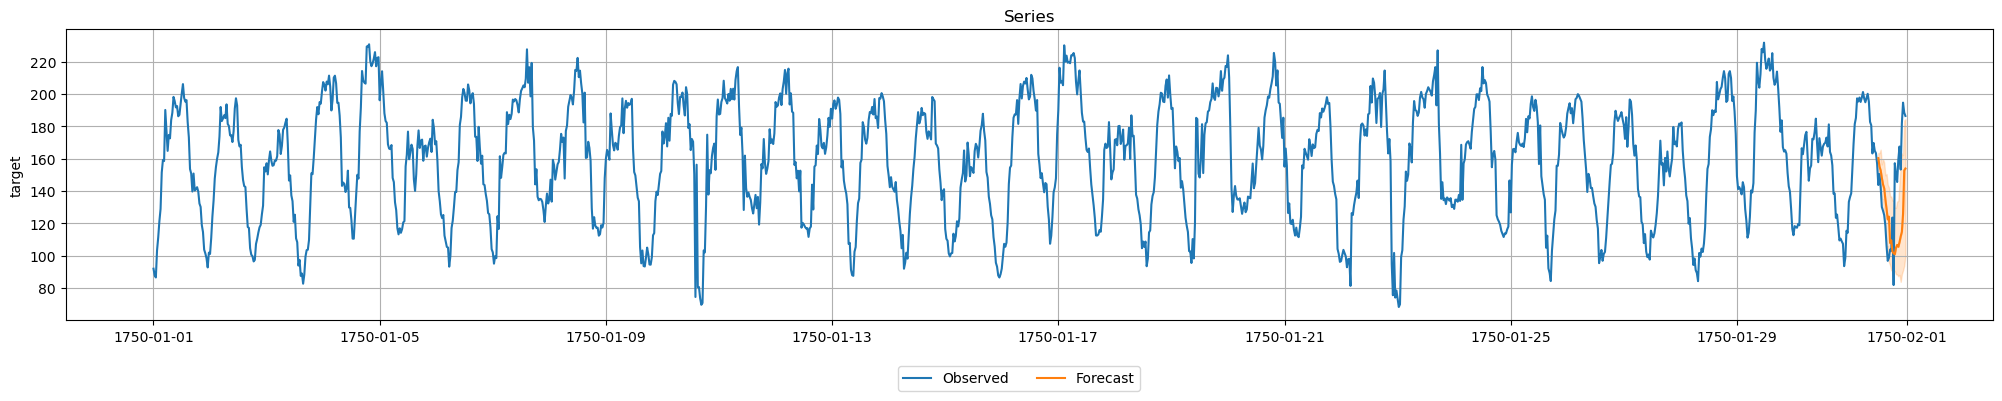

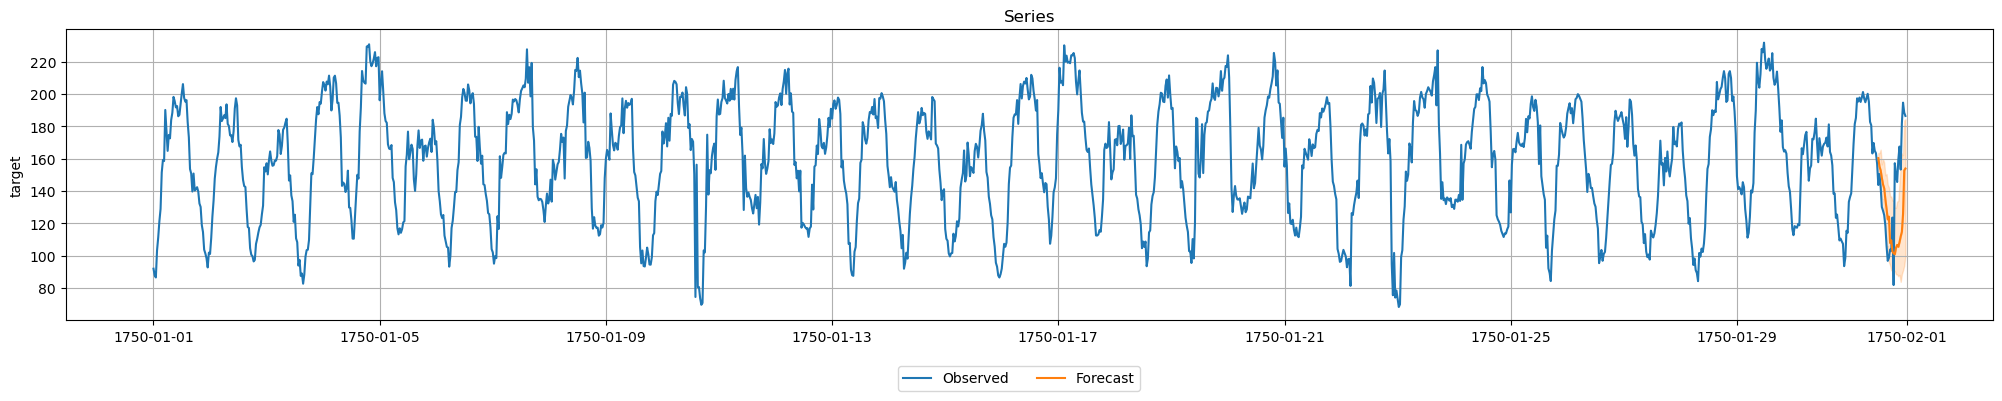

In [9]:
Len = data.shape[0]
predictor.plot(
    data=data, 
    predictions=predictions, 
    item_ids=["Series"],
    max_history_length=Len,
)

# Generate Clean Anomaly data

In [10]:
# df = pd.read_csv('anomaly.csv')
# L = []
# for d in range(1,124): # each day for 123 days starting at day 1
#     for h in range(0,24): # each hour
#         for m in range(0,2):  # every 30 min
#             L.append(f"1750-01-{d:02d} {h:02d}:{m*30:02d}:00")
# Len = len(L)
# df = df.loc[:Len-1,['item_id','timestamp','target']]
# df.timestamp = L
# df = df[['item_id','timestamp','target']]
# df.to_csv('anomalySeries.csv', index= False)
# df
